https://github.com/keyonvafa/Gaussian-Process/blob/master/GP%20Regression.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
%matplotlib inline

Data

In [2]:
x = np.array([-1.5,-.9,-.75,-.6,-.25,0])
y = np.array([-1.8,-1.2,-.3,.2,.5,.6])

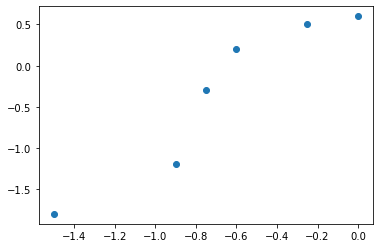

In [5]:
plt.scatter(x,y)
pass

Linear Model

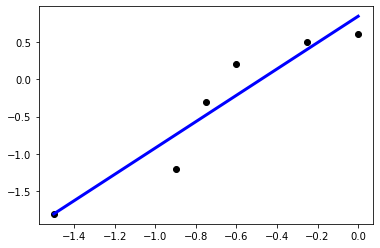

In [9]:
x_train = [[x[i]] for i in range(len(x))]
y_train = [[y[i]] for i in range(len(y))]
clf = linear_model.LinearRegression()
clf.fit(x_train,y_train)
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, clf.predict(x_train), color='blue',linewidth=3)
pass

Gaussian Regression, with optimizing parameters

In [13]:
x = np.array([-1.5,-1.2,-.9,-.75,-.6,-.25,0])
y = np.array([-1.8,-1.7,-1.2,-.3,.2,.5,.6])
sigma_n = np.var(y)
n = len(x)

In [52]:
sigma_n

0.9077551020408162

In [16]:
#x = np.arange(-5,5,.5)
#y = x+np.random.normal(0,.2,len(x))
#sigma_n = np.var(y)
#n = len(x)

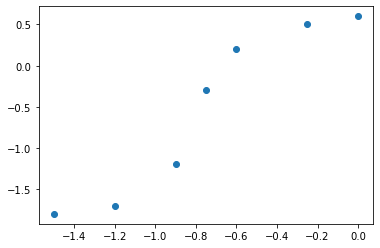

In [17]:
plt.scatter(x,y)
pass

In [34]:
def dK_dtheta1(theta1,theta2):
    l = np.exp(theta1)
    sig = np.exp(2*theta2)
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = sig*np.exp((-1.0*(x[i]-x[j])**2)/l)*((1.0*(x[i]-x[j])**2)/l)
    return K

In [35]:
def dK_dtheta2(theta1,theta2):
    l = np.exp(theta1)
    sig = np.exp(2*theta2)
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = 2*sig*np.exp((-1.0*(x[i]-x[j])**2)/l)
    return K

In [36]:
def kernel(i,j,theta1,theta2):
    l = np.exp(theta1)
    sig = np.exp(2*theta2)
    return sig*np.exp((-1.0*(i-j)**2)/l)+sigma_n*int(i == j)

In [37]:
def create_K(theta1,theta2):
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = kernel(x[i],x[j],theta1,theta2)
    return K

In [38]:
def grad(theta1,theta2):
    w = np.zeros(2)
    K = create_K(theta1,theta2)
    K_inv = np.linalg.inv(K)
    dKdt1 = dK_dtheta1(theta1,theta2)
    dKdt2 = dK_dtheta2(theta1,theta2)
    # We don't compute the product before taking the trick -- using np.einsum saves times
    w[0] = -.5*(np.einsum('ij,ji->', K_inv, dKdt1)-np.dot(np.dot(np.dot(np.dot(y.T,K_inv),dKdt1),K_inv),y)) 
    w[1] = -.5*(np.einsum('ij,ji->', K_inv, dKdt2)-np.dot(np.dot(np.dot(np.dot(y.T,K_inv),dKdt2),K_inv),y))
    return w

In [39]:
def train(epoch= 1000,stepsize = .01):
    w = np.random.rand(2)
    for i in range(epoch):
        w = w +stepsize*grad(w[0],w[1])
    return(w)

In [40]:
#w0,w1 = train()
#loglik(w0,w1)

In [41]:
def loglik(theta1,theta2):
    K = create_K(theta1,theta2)
    K_inv = np.linalg.inv(K)
    return -.5*np.log(np.linalg.det(K))-.5*np.dot(np.dot(y.T,K_inv),y)

In [42]:
def create_K_star(x_new,theta1,theta2):
    K_star = np.zeros((1,n))
    for i in range(n):
        K_star[0,i] = kernel(x_new,x[i],theta1,theta2)
    return K_star

In [43]:
def predict_and_error(x_new,theta1,theta2,K_inv):
    K_star = create_K_star(x_new,theta1,theta2)
    K_star_star = kernel(x_new,x_new,theta1,theta2)
    ybar_star = np.dot(np.dot(K_star,K_inv),y)
    var_y_star = K_star_star - np.dot(np.dot(K_star,K_inv),K_star.T)
    return(ybar_star[0],var_y_star[0][0])

In [44]:
def plot_preds(theta1,theta2,xmin = np.min(x)-1,xmax = np.max(x)+1,by = .1):
    K = create_K(theta1,theta2)
    K_inv = np.linalg.inv(K)
    p_x = np.arange(xmin,xmax,by)
    p_y = np.array([predict_and_error(x_new,theta1,theta2,K_inv)[0] for x_new in p_x])
    errs = np.array([predict_and_error(x_new,theta1,theta2,K_inv)[1] for x_new in p_x])
    lower = p_y - 1.96*np.sqrt(errs)
    upper = p_y + 1.96*np.sqrt(errs)
    plt.plot(x,y,'bo',label='Sample observations')
    plt.plot(p_x,p_y,'r-',label='Regression line')
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

-0.1309874943522825 -0.0014558191993521252


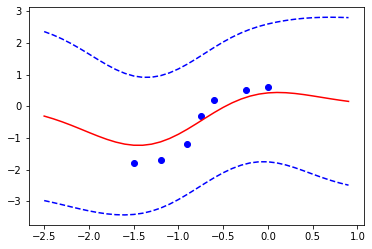

In [48]:
theta1,theta2 = train()
plot_preds(theta1,theta2)
print (theta1,theta2)

Helper Functions for checking

In [49]:
def gridsearch():
    maxi = 0
    maxj = 0
    maxlik = -1000
    for i in np.arange(-.5,.5,.01):
        for j in np.arange(-.5,.5,.01):
            if loglik(i,j) > maxlik:
                maxi = i
                maxj = j
                maxlik = loglik(i,j)
    theta1 = maxi
    theta2 = maxj
    return np.array([theta1,theta2])

In [50]:
def finitedifference(theta1,theta2,eps):
    w = np.zeros(2)
    w[0] = (loglik(theta1+eps,theta2)-loglik(theta1-eps,theta2))/(2*eps) 
    w[1] = (loglik(theta1,theta2+eps)-loglik(theta1,theta2-eps))/(2*eps)
    return w